# 2/22/21 - This notebook applies LightAndMassProfiles and dark matter profiles to the fit.
https://github.com/Jammy2211/autolens_workspace/blob/release/notebooks/imaging/modeling/light_parametric__mass_light_dark__source_parametric.ipynb

In [1]:
### libraries
%matplotlib inline
# set workspace path
from pyprojroot import here
workspace_path = str(here())#'/data/sknabel/autolens_workspace'
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

import matplotlib.pyplot as plt
from autoconf import conf
import autolens as al
import autolens.plot as aplt
import autofit as af
import pandas as pd
import numpy as np
from astropy.io import fits
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)
from astropy.stats import sigma_clip as clip
from os import path
import time

# set datetime variable
datetime = time.strftime("%d%m%Y-%H%M%S")

# paths
autoz_path = '/data/sknabel/autoz_lens_model/'
file_path = f'{autoz_path}files/'
csv_path = f'{file_path}csv/'
fits_path = f'{file_path}fits/'
png_path = f'{autoz_path}visuals/png/'
pdf_path = f'{autoz_path}visuals/pdf/'
object_folder = f'{fits_path}G3575500_1906/'

In /soft/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /soft/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /soft/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /soft/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /soft/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_tes

/data/sknabel/autoz_lens_model
Working Directory has been set to `/data/sknabel/autoz_lens_model`


Lens and source redshifts at [0.2325366] and [0.36519459].
Einstein radius prior: [1.02937223]
Plotting r-band


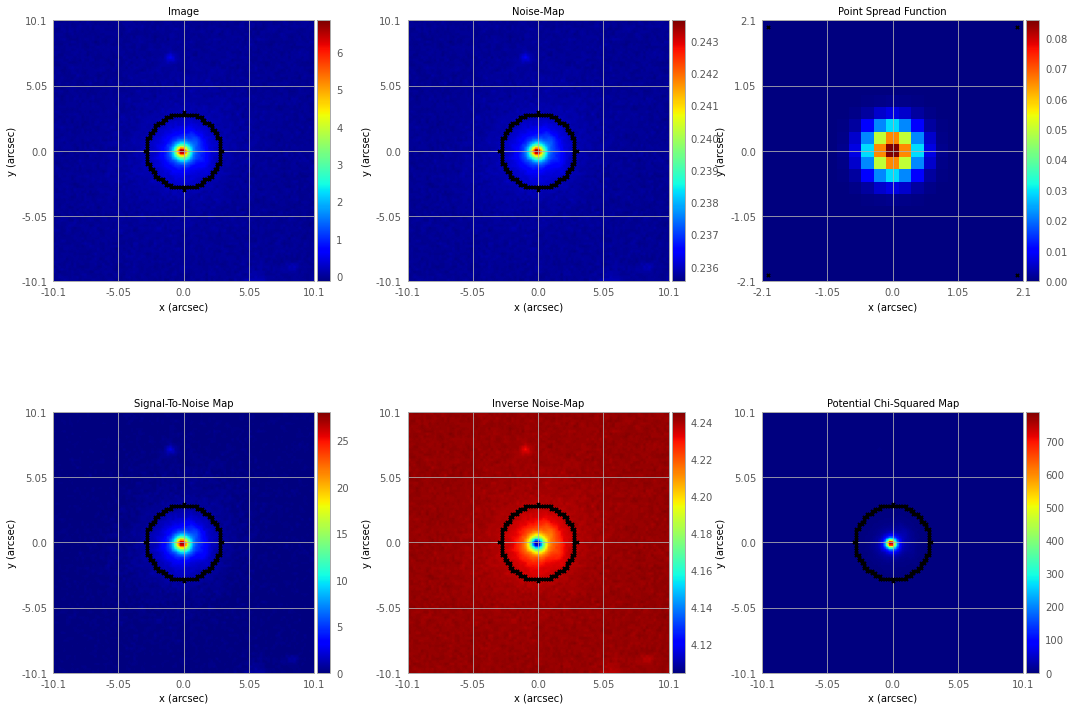

Plotting g-band


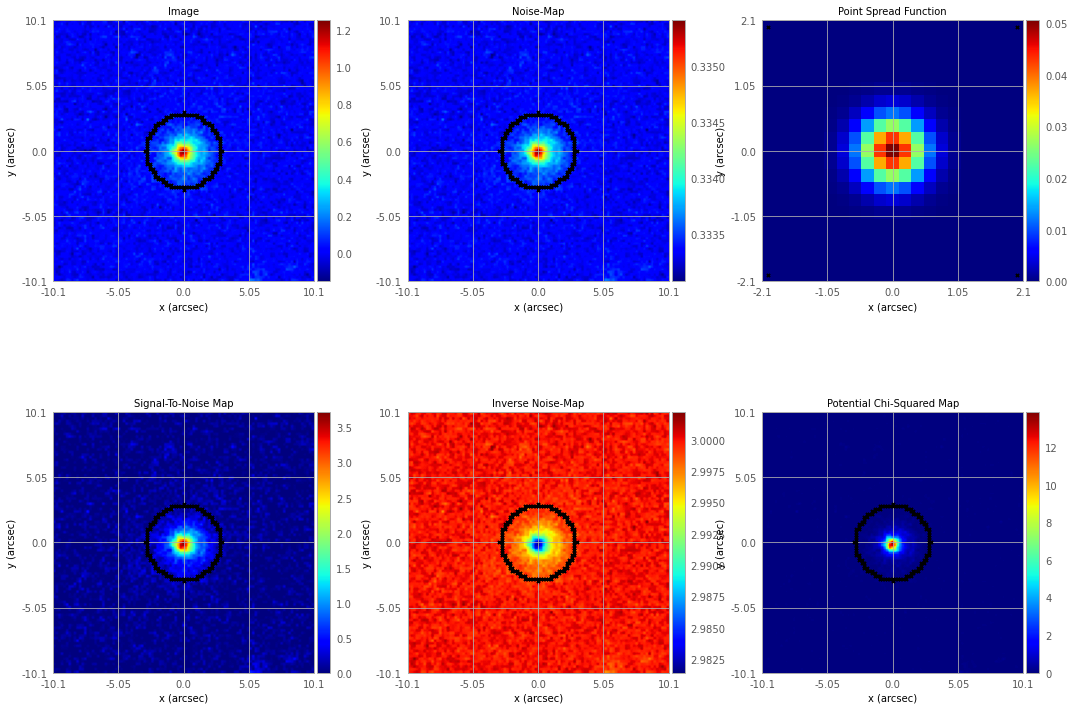

In [44]:
# this should be constant across experiments

# load object data table
links = pd.read_csv(f'{csv_path}/latest/links_sample_latest.csv')
lens_galaxy_data = links[links.GAMA_ID == 3575500]
zlens=lens_galaxy_data.zlens.values
zsource=lens_galaxy_data.zsource.values
einstein_radius=(lens_galaxy_data.theta_e_pm.values+lens_galaxy_data.theta_e_sis.values)/2 # take average of einstein radius estimates for prior
print(f'Lens and source redshifts at {zlens} and {zsource}.')
print(f'Einstein radius prior: {einstein_radius}')

# load r-band imaging
imaging_r = al.Imaging.from_fits(image_path=path.join(object_folder, '1906_r_image.fits'),
                              noise_map_path=path.join(object_folder, '1906_r_noisemap.fits'),
                              psf_path=path.join(object_folder, '1906_r_psf_resized.fits'),
                               pixel_scales=0.2)

# set up mask
mask = al.Mask2D.circular(
    shape_native=imaging_r.shape_native, pixel_scales=imaging_r.pixel_scales, sub_size=2, radius=3.0
)
visuals_2d = aplt.Visuals2D(mask=mask)

# plot subplots for first view
print('Plotting r-band')
imaging_plotter_r = aplt.ImagingPlotter( # this is where the noise is coming up weird
    imaging=imaging_r, visuals_2d=aplt.Visuals2D(mask=mask)
)
imaging_plotter_r.subplot_imaging()

# load g-band imaging
imaging_g = al.Imaging.from_fits(image_path=path.join(object_folder, '1906_g_image.fits'),
                              noise_map_path=path.join(object_folder, '1906_g_noisemap.fits'),
                              psf_path=path.join(object_folder, '1906_g_psf_resized.fits'),
                               pixel_scales=0.2)
# same mask
print('Plotting g-band')
imaging_plotter_g = aplt.ImagingPlotter( # this is where the noise is coming up weird
    imaging=imaging_g, visuals_2d=aplt.Visuals2D(mask=mask)
)
imaging_plotter_g.subplot_imaging()

# set up grid and settings
settings_masked_imaging = al.SettingsMaskedImaging(grid_class=al.Grid2D)#, psf_shape_2d=imaging.psf.shape_2d)
settings = al.SettingsPhaseImaging(settings_masked_imaging=settings_masked_imaging)

#set up lens light profile
lens_start = al.GalaxyModel(
    redshift=zlens, bulge=al.lp.EllipticalSersic#, mass=al.mp.EllipticalIsothermal
)

# set priors
# lens position
lens_start.bulge.centre_0 = af.UniformPrior(lower_limit=-0.1, upper_limit=0.1)
lens_start.bulge.centre_1 = af.UniformPrior(lower_limit=-0.1, upper_limit=0.1)
# effective radius
#lens_start.bulge.effective_radius = af.UniformPrior(lower_limit=0.0, upper_limit=5.0) # why have I chosen 3 here? because the mask is 3...

In [17]:
# set up tools for tracking the experiments (log of outputs and table of time to convergence and log likelihood)

#Start a log.txt file
#log = open(f"{autoz_path}output/G3575500/dark_experiment_log_G3575500", 'a')
#log.write(f'This logs the outputs from autolens experiments on G3575500_1906 beginning on datetime {datetime}. PARTY ON WAYNE! \n')
#log.write(f'\n')
#log.close()

# Start a pandas dataframe
#performance_log = pd.DataFrame(columns=['Experiment', 
#                                        'phase1_time', 
#                                        'phase1_likelihood', 
#                                        'phase2_time', 
#                                        'phase2_likelihood' 
#                                        ])

# load performance log from csv
performance_log = pd.read_csv(f'{csv_path}G3575500_performance_log.csv')
#print(performance_log)
#performance_log.rename(columns={'phase1_time.1':'phase1_likelihood'}, inplace=True)
#performance_log.to_csv(f'{csv_path}G3575500_performance_log.csv')
print(performance_log)

    Unnamed: 0  Unnamed: 0.1 Experiment  phase1_time  phase1_likelihood  \
0            0             0        1-1   107.555079         296.239404   
1            1             0        1-2   137.521799         296.010310   
2            2             0        1-3   104.364316         296.235893   
3            3             0        1-4    73.453015         296.132388   
4            4             0        1-5    40.029995         296.179939   
5            5             0        1-6    34.548316         286.543298   
6            6             0        1-7    11.370712        -208.230643   
7            7             0        2-1    31.438987         293.256161   
8            8             0        2-2    30.512206         290.287783   
9            9             0        2-3    33.163424         294.155040   
10          10             0        2-4    34.001947         295.772725   
11          11             0        2-5    34.957396         294.779695   
12          12           

## Experiment 1: Dark matter - positions

positions_threshold = 2, 3, 4

In [4]:
# set experiment number
experiment_number = '1-DM-positions'

# set up phase
phase1 = al.PhaseImaging(
    search=af.DynestyStatic(
        path_prefix="G3575500", name=f"experiment_{experiment_number}_r_fit_{datetime}", n_live_points=40,
        evidence_tolerance=1
    ),
    settings=settings,
    galaxies=af.CollectionPriorModel(lens=lens_start)#, source=source)
)

In [5]:
# run the phase
print('Phase running...')
tick = time.perf_counter()
phase1_result = phase1.run(dataset=imaging_r, mask=mask)
tock = time.perf_counter()
print(f'Work complete! Took us {tock-tick} seconds or {(tock-tick)/60} minutes.')

Phase running...


INFO:root:Generating initial samples of model, which are subject to prior limits and other constraints.
INFO:root:No Dynesty samples found, beginning new non-linear search. 
161it [00:08, 23.94it/s, bound: 8 | nc: 7 | ncall: 1534 | eff(%): 10.495 | loglstar:   -inf < -914.048 <    inf | logz: -922.406 +/-    nan | dlogz: 1051.541 >  1.000]   /soft/anaconda3/lib/python3.7/site-packages/dynesty/sampling.py:216: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
164it [00:08, 20.85it/s, bound: 9 | nc: 5 | ncall: 1565 | eff(%): 10.479 | loglstar:   -inf < -852.700 <    inf | logz: -860.390 +/-    nan | dlogz: 900.975 >  1.000] /soft/anaconda3/lib/python3.7/site-packages/dynesty/sampling.py:216: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
274it

Work complete! Took us 58.46996406465769 seconds or 0.9744994010776281 minutes.


Log likelihood: 300.58542867714533


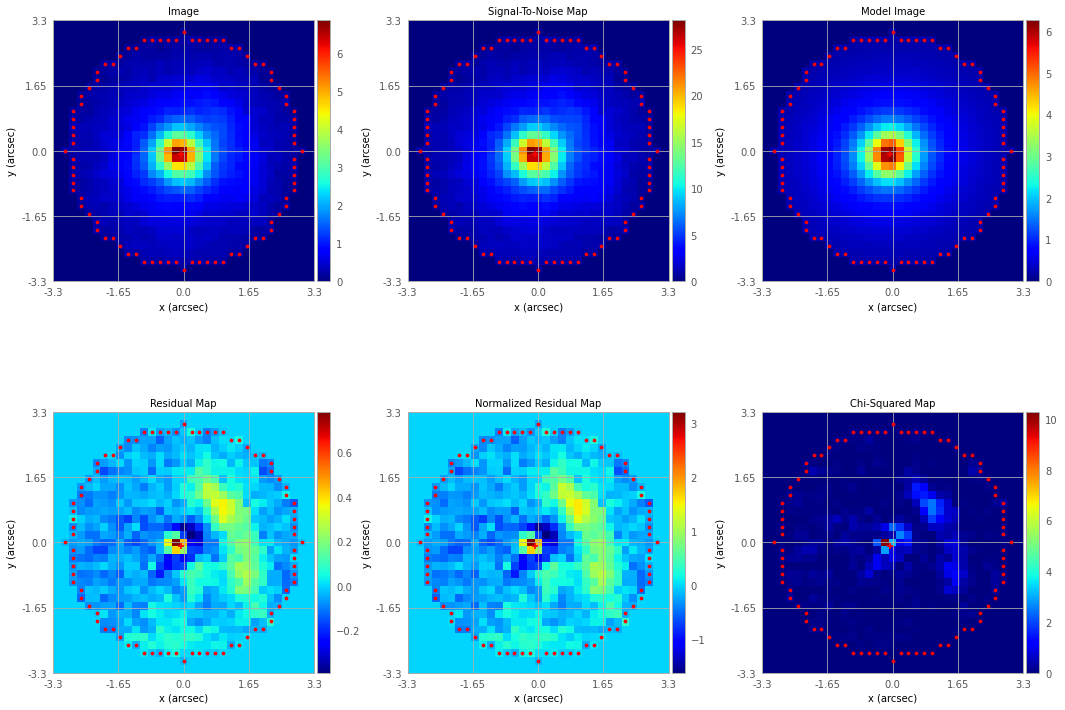

In [6]:
# write the results to the log
print(f'Log likelihood: {phase1_result.log_likelihood}')

phase1_time = tock-tick

# plot it!
fit_imaging_plotter = aplt.FitImagingPlotter(fit=phase1_result.max_log_likelihood_fit)
fit_imaging_plotter.subplot_fit_imaging()

In [7]:
# now phase 2!

#set up lens and source

# set stellar mass/light profile
bulge = af.PriorModel(al.lmp.EllipticalSersic)
bulge.take_attributes(source=phase1_result.model.galaxies.lens.bulge)

# set dark matter profile
dark = af.PriorModel(al.mp.SphericalNFWMCRLudlow)
dark.mass_at_200 = af.LogUniformPrior(lower_limit=1e8, upper_limit=1e15)
dark.redshift_object = zlens
dark.redshift_source = zsource

lens = al.GalaxyModel(
    redshift=zlens, bulge=bulge, dark=dark
)

source = al.GalaxyModel(
    redshift=zsource, bulge=al.lp.SphericalExponential)

# make lens intensity default to 0.1 +- 0.1 because red to green makes it wonky
lens.bulge.intensity = af.GaussianPrior(mean=0.1, sigma=0.1)

# set uniform m_l ratio
#lens.bulge.mass_to_light_ratio = af.UniformPrior(lower_limit=0.0, upper_limit=100000.0) # leave it default

# make dark matter centered at stellar mass center
lens.dark.centre = lens.bulge.centre

# einstein radius
#lens.mass.einstein_radius = af.GaussianPrior(mean=einstein_radius, sigma=0.3*einstein_radius) # take sigma to be 30% of mean # hmmm

# source position
source.bulge.centre_0 = af.UniformPrior(lower_limit=-3, upper_limit=3)
source.bulge.centre_1 = af.UniformPrior(lower_limit=-3, upper_limit=3)
source.bulge.effective_radius = af.UniformPrior(lower_limit=0.0, upper_limit=5.0)

Plotting g-band


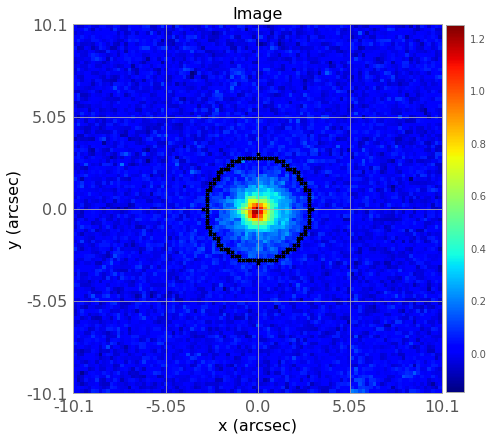

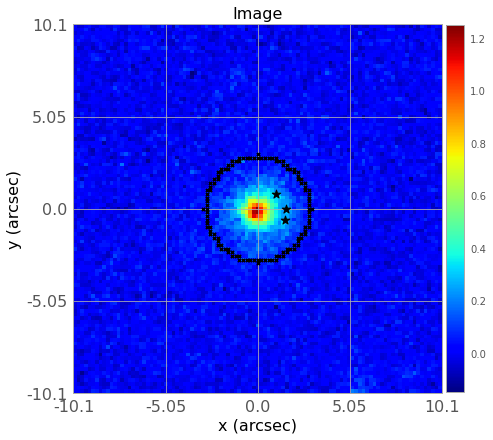

In [8]:
# Set up the positions... (GUI is not working...)

# plot the g-band image to see it
print('Plotting g-band')
imaging_plotter_g = aplt.ImagingPlotter( # this is where the noise is coming up weird
    imaging=imaging_g, visuals_2d=aplt.Visuals2D(mask=mask)
)
imaging_plotter_g.figures(image=True)

# set positions
imaging_g.positions = al.Grid2DIrregular(
    [(0.0, 1.55), (-0.6, 1.5), (0.8, 1.0)]
)

# plot the image
visuals_2d = aplt.Visuals2D(mask=mask, positions=imaging_g.positions)
imaging_plotter_g = aplt.ImagingPlotter(imaging=imaging_g, visuals_2d=visuals_2d)
imaging_plotter_g.figures(image=True)

In [9]:
# set the settings to include the positions
settings_lens = al.SettingsLens(positions_threshold=2.0)

settings = al.SettingsPhaseImaging(
    settings_masked_imaging=settings_masked_imaging, settings_lens=settings_lens
)

In [11]:
# set up phase
phase2 = al.PhaseImaging(
    search=af.DynestyStatic(
        path_prefix="G3575500", name=f"experiment_{experiment_number}_g_fit_{datetime}", n_live_points=120,
        evidence_tolerance=0.5, walks=5, facc=0.4
    ),
    settings=settings,
    galaxies=af.CollectionPriorModel(lens=lens, source=source)#, source=source)
)

In [12]:
# run phase
# run the phase
print('Phase running...')
tick = time.perf_counter()
phase2_result = phase2.run(dataset=imaging_g, mask=mask)
tock = time.perf_counter()
print(f'Work complete! Took us {tock-tick} seconds or {(tock-tick)/60} minutes.')

INFO:root:Generating initial samples of model, which are subject to prior limits and other constraints.


Phase running...


INFO:root:No Dynesty samples found, beginning new non-linear search. 
286it [01:32,  3.10it/s, +120 | bound: 0 | nc: 1 | ncall: 2682 | eff(%): 15.138 | loglstar:   -inf < 115.296 <    inf | logz: 107.682 +/-  0.795 | dlogz:  0.940 >  0.500]    
INFO:root:2500 Iterations: Performing update (Visualization, outputting samples, etc.).
664it [02:18,  4.81it/s, +120 | bound: 24 | nc: 1 | ncall: 5186 | eff(%): 15.118 | loglstar:   -inf < 116.963 <    inf | logz: 108.465 +/-  0.581 | dlogz:  0.152 >  0.500]
INFO:root:5000 Iterations: Performing update (Visualization, outputting samples, etc.).
1036it [02:31,  6.84it/s, +120 | bound: 50 | nc: 1 | ncall: 7690 | eff(%): 15.033 | loglstar:   -inf < 118.119 <    inf | logz: 108.897 +/-  0.440 | dlogz:  0.015 >  0.500]
INFO:root:7500 Iterations: Performing update (Visualization, outputting samples, etc.).
1209it [01:05, 18.32it/s, +120 | bound: 61 | nc: 1 | ncall: 8792 | eff(%): 15.116 | loglstar:   -inf < 118.262 <    inf | logz: 108.925 +/-  0.379

Work complete! Took us 521.4613352492452 seconds or 8.691022254154086 minutes.


In [13]:
# write the results to the log
print(f'Log likelihood: {phase2_result.log_likelihood}')

phase2_time=tock-tick

log = open(f"{autoz_path}output/G3575500/dark_experiment_log_G3575500", 'a') # append the log
lines = [f'Experiment {experiment_number} \n',
         f'r-band \n',
         f'Time to convergence: {phase1_time} seconds \n', 
         f'Log likelihood: {phase1_result.log_likelihood} \n',
         f'Model: {str(phase1_result.model)} \n',
         f'g-band \n',
         f'Time to convergence: {phase2_time} seconds \n', 
         f'Log likelihood: {phase2_result.log_likelihood} \n', 
         f'Model: {str(phase2_result.model)} \n', '\n'] # set lines to write the model result
log.writelines(lines) # write lines
log.close()

Log likelihood: 118.26163784773334


    Unnamed: 0  Unnamed: 0.1      Experiment  phase1_time  phase1_likelihood  \
0          0.0           0.0             1-1   107.555079         296.239404   
1          1.0           0.0             1-2   137.521799         296.010310   
2          2.0           0.0             1-3   104.364316         296.235893   
3          3.0           0.0             1-4    73.453015         296.132388   
4          4.0           0.0             1-5    40.029995         296.179939   
5          5.0           0.0             1-6    34.548316         286.543298   
6          6.0           0.0             1-7    11.370712        -208.230643   
7          7.0           0.0             2-1    31.438987         293.256161   
8          8.0           0.0             2-2    30.512206         290.287783   
9          9.0           0.0             2-3    33.163424         294.155040   
10        10.0           0.0             2-4    34.001947         295.772725   
11        11.0           0.0            

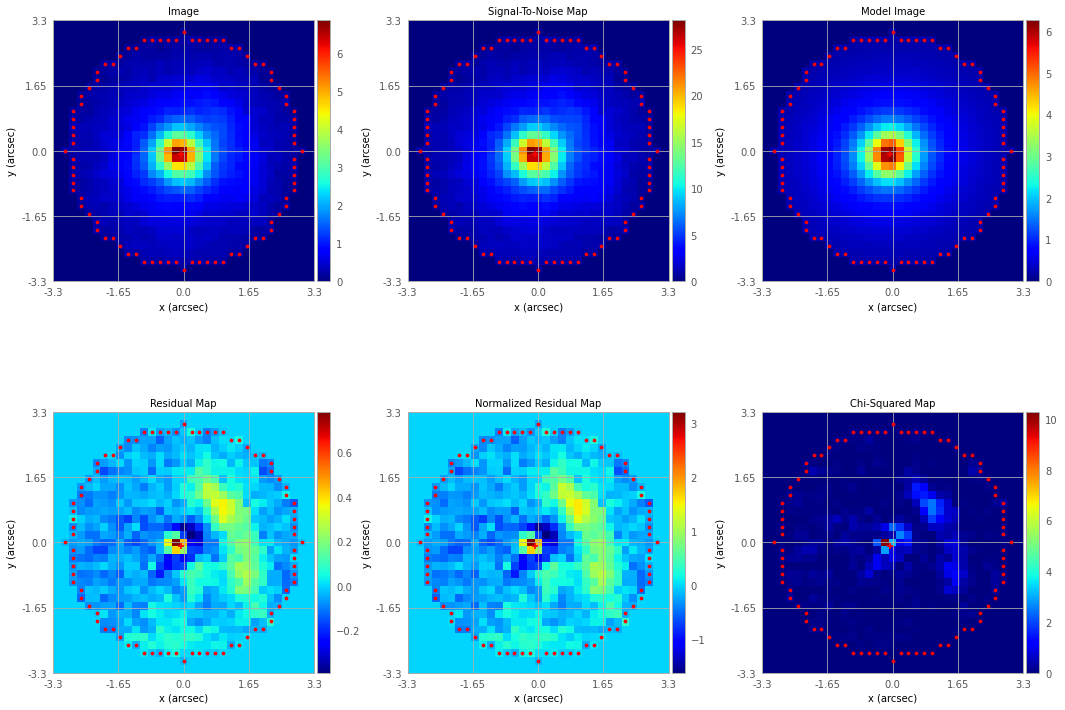

In [19]:
# append performance log
data_list = [[experiment_number, 
            phase1_time,
            phase1_result.log_likelihood,
            phase2_time, 
            phase2_result.log_likelihood,
              0, 0
             ]]
new_dataframe_entry = pd.DataFrame(data_list,
                                  columns=['Experiment', 
                                           'phase1_time', 
                                           'phase1_likelihood', 
                                           'phase2_time', 
                                           'phase2_likelihood', 
                                           'phase3_time',
                                           'phase3_likelihood'
                                           ])
performance_log = pd.concat([performance_log, new_dataframe_entry])
print(performance_log)
performance_log.to_csv(f'{csv_path}G3575500_performance_log.csv')
#print(phase_result.model)
# get samples to see how it ran?
#log_likelihoods = phase_result.samples.log_likelihoods
#x = np.arange(0, len(log_likelihoods), 1)
#plt.plot(x[500:], log_likelihoods[500:])
#plt.xlim()

# plot it!
fit_imaging_plotter = aplt.FitImagingPlotter(fit=phase1_result.max_log_likelihood_fit)
fit_imaging_plotter.subplot_fit_imaging()

# New experiment: All with DM profiles

## *** Model
### Phase 1 - Dynesty(n_live=40, tolerance=1, walks=default)
### Phase 2 - Dynesty(n_live=120, tolerance=0.5, walks=10, facc=0.4)
## ***

1. Effective radius (w/o positions)

- 1. 0.65 - 5.0

- 2. 0.65 - 10.0

2. Positions

- 1. Set positions(position_threshold=2.0)

- 2. Set positions(position_threshold=1.5)

- 3. Set positions(position_threshold=1.0)

- 4. Set positions(position_threshold=0.5)

## Experiment 1-1: Effective radius (0.65 - 5.0)

In [25]:
# set experiment number
experiment_number = 'DM_1-1_eff_radius_0.65-5.0'

# effective radius
lens_start.bulge.effective_radius = af.UniformPrior(lower_limit=0.65, upper_limit=5.0) # why have I chosen 3 here?

# set up phase
phase1 = al.PhaseImaging(
    search=af.DynestyStatic(
        path_prefix="G3575500/DM_experiments", name=f"experiment_{experiment_number}_r_fit_{datetime}", n_live_points=40,
        evidence_tolerance=1
    ),
    settings=settings,
    galaxies=af.CollectionPriorModel(lens=lens_start)#, source=source)
)

In [26]:
# run the phase
print('Phase running...')
tick = time.perf_counter()
phase1_result = phase1.run(dataset=imaging_r, mask=mask)
tock = time.perf_counter()
print(f'Work complete! Took us {tock-tick} seconds or {(tock-tick)/60} minutes.')

INFO:root:Generating initial samples of model, which are subject to prior limits and other constraints.


Phase running...


INFO:root:No Dynesty samples found, beginning new non-linear search. 
277it [00:12, 21.46it/s, +40 | bound: 28 | nc: 1 | ncall: 2547 | eff(%): 12.446 | loglstar:   -inf < 253.029 <    inf | logz: 241.783 +/-    nan | dlogz:  1.099 >  1.000] 
INFO:root:2500 Iterations: Performing update (Visualization, outputting samples, etc.).
573it [00:12, 44.75it/s, +40 | bound: 100 | nc: 1 | ncall: 5049 | eff(%): 12.141 | loglstar:   -inf < 297.474 <    inf | logz: 278.976 +/-    nan | dlogz:  1.061 >  1.000]
INFO:root:5000 Iterations: Performing update (Visualization, outputting samples, etc.).
855it [00:11, 71.95it/s, +40 | bound: 166 | nc: 1 | ncall: 7430 | eff(%): 12.046 | loglstar:   -inf < 300.964 <    inf | logz: 279.824 +/-    nan | dlogz:  0.025 >  1.000]
INFO:root:7500 Iterations: Performing update (Visualization, outputting samples, etc.).
855it [00:00, 531751.17it/s, +40 | bound: 166 | nc: 1 | ncall: 7430 | eff(%): 12.046 | loglstar:   -inf < 300.964 <    inf | logz: 279.824 +/-    nan 

Work complete! Took us 58.38562412187457 seconds or 0.9730937353645762 minutes.


Log likelihood: 300.9637438261428


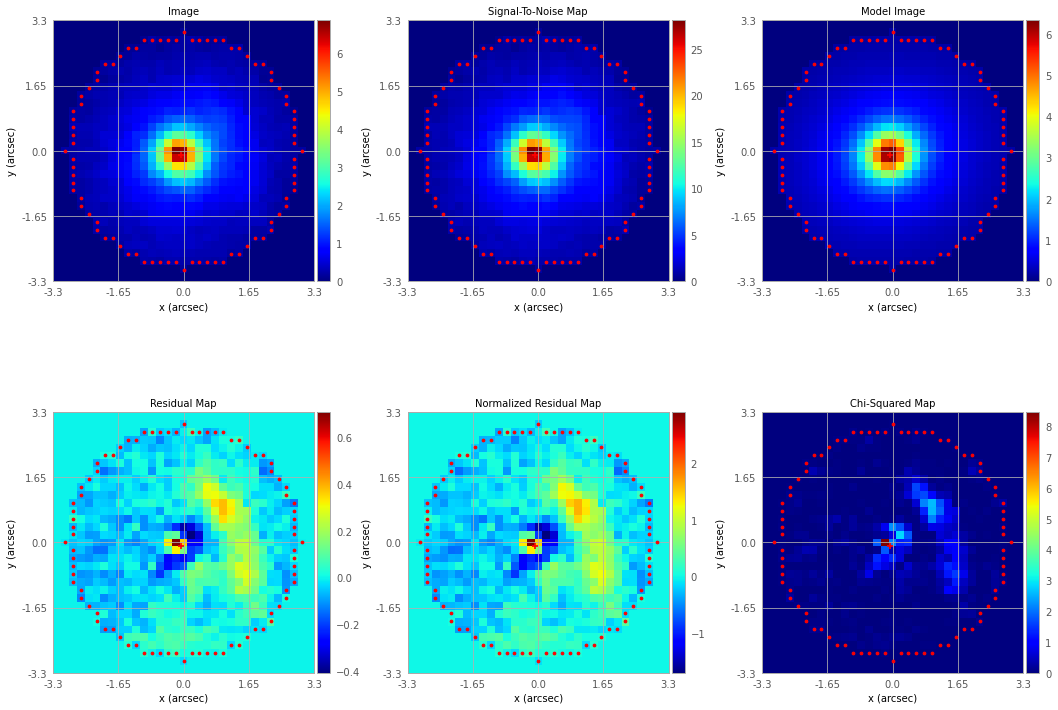

In [27]:
# write the results to the log
print(f'Log likelihood: {phase1_result.log_likelihood}')

phase1_time = tock-tick

# plot it!
fit_imaging_plotter = aplt.FitImagingPlotter(fit=phase1_result.max_log_likelihood_fit)
fit_imaging_plotter.subplot_fit_imaging()

In [28]:
# now phase 2!

#set up lens and source

# set stellar mass/light profile
bulge = af.PriorModel(al.lmp.EllipticalSersic)
bulge.take_attributes(source=phase1_result.model.galaxies.lens.bulge)

# set dark matter profile
dark = af.PriorModel(al.mp.SphericalNFWMCRLudlow)
dark.mass_at_200 = af.LogUniformPrior(lower_limit=1e8, upper_limit=1e15)
dark.redshift_object = zlens
dark.redshift_source = zsource

lens = al.GalaxyModel(
    redshift=zlens, bulge=bulge, dark=dark
)

source = al.GalaxyModel(
    redshift=zsource, bulge=al.lp.SphericalExponential)

# make lens intensity default to 0.1 +- 0.1 because red to green makes it wonky
lens.bulge.intensity = af.GaussianPrior(mean=0.1, sigma=0.1)

# set uniform m_l ratio
#lens.bulge.mass_to_light_ratio = af.UniformPrior(lower_limit=0.0, upper_limit=100000.0) # leave it default

# make dark matter centered at stellar mass center
lens.dark.centre = lens.bulge.centre

# einstein radius
#lens.mass.einstein_radius = af.GaussianPrior(mean=einstein_radius, sigma=0.3*einstein_radius) # take sigma to be 30% of mean # hmmm

# source position
source.bulge.centre_0 = af.UniformPrior(lower_limit=-3, upper_limit=3)
source.bulge.centre_1 = af.UniformPrior(lower_limit=-3, upper_limit=3)
source.bulge.effective_radius = af.UniformPrior(lower_limit=0.0, upper_limit=5.0)

In [29]:
# set the settings to include the positions
#settings_lens = al.SettingsLens(positions_threshold=2.0)

settings = al.SettingsPhaseImaging(
    settings_masked_imaging=settings_masked_imaging#, settings_lens=settings_lens
)

In [30]:
# set up phase
phase2 = al.PhaseImaging(
    search=af.DynestyStatic(
        path_prefix="G3575500/DM_experiments", name=f"experiment_{experiment_number}_g_fit_{datetime}", n_live_points=120,
        evidence_tolerance=0.5, walks=10, facc=0.4
    ),
    settings=settings,
    galaxies=af.CollectionPriorModel(lens=lens, source=source)#, source=source)
)

In [31]:
# run phase
# run the phase
print('Phase running...')
tick = time.perf_counter()
phase2_result = phase2.run(dataset=imaging_g, mask=mask)
tock = time.perf_counter()
print(f'Work complete! Took us {tock-tick} seconds or {(tock-tick)/60} minutes.')

INFO:root:Generating initial samples of model, which are subject to prior limits and other constraints.


Phase running...


INFO:root:No Dynesty samples found, beginning new non-linear search. 
369it [02:11,  2.81it/s, +120 | bound: 0 | nc: 1 | ncall: 2685 | eff(%): 18.212 | loglstar:   -inf < 115.714 <    inf | logz: 108.290 +/-  0.511 | dlogz:  0.499 >  0.500]   
INFO:root:2500 Iterations: Performing update (Visualization, outputting samples, etc.).
486it [02:07,  3.82it/s, +120 | bound: 4 | nc: 1 | ncall: 5195 | eff(%): 11.665 | loglstar:   -inf < 115.850 <    inf | logz: 108.119 +/-  0.600 | dlogz:  0.288 >  0.500]
INFO:root:5000 Iterations: Performing update (Visualization, outputting samples, etc.).
684it [02:12,  5.16it/s, +120 | bound: 18 | nc: 1 | ncall: 7698 | eff(%): 10.444 | loglstar:   -inf < 117.223 <    inf | logz: 108.874 +/-  0.545 | dlogz:  0.113 >  0.500]
INFO:root:7500 Iterations: Performing update (Visualization, outputting samples, etc.).
922it [02:13,  6.92it/s, +120 | bound: 32 | nc: 1 | ncall: 10205 | eff(%): 10.211 | loglstar:   -inf < 117.391 <    inf | logz: 109.090 +/-  0.390 | 

Work complete! Took us 762.9184863306582 seconds or 12.71530810551097 minutes.


In [32]:
# write the results to the log
print(f'Log likelihood: {phase2_result.log_likelihood}')

phase2_time=tock-tick

log = open(f"{autoz_path}output/G3575500/dark_experiment_log_G3575500", 'a') # append the log
lines = [f'Experiment {experiment_number} \n',
         f'r-band \n',
         f'Time to convergence: {phase1_time} seconds \n', 
         f'Log likelihood: {phase1_result.log_likelihood} \n',
         f'Model: {str(phase1_result.model)} \n',
         f'g-band \n',
         f'Time to convergence: {phase2_time} seconds \n', 
         f'Log likelihood: {phase2_result.log_likelihood} \n', 
         f'Model: {str(phase2_result.model)} \n', '\n'] # set lines to write the model result
log.writelines(lines) # write lines
log.close()

Log likelihood: 117.74018984677448


    Unnamed: 0  Unnamed: 0.1                  Experiment  phase1_time  \
0          0.0           0.0                         1-1   107.555079   
1          1.0           0.0                         1-2   137.521799   
2          2.0           0.0                         1-3   104.364316   
3          3.0           0.0                         1-4    73.453015   
4          4.0           0.0                         1-5    40.029995   
5          5.0           0.0                         1-6    34.548316   
6          6.0           0.0                         1-7    11.370712   
7          7.0           0.0                         2-1    31.438987   
8          8.0           0.0                         2-2    30.512206   
9          9.0           0.0                         2-3    33.163424   
10        10.0           0.0                         2-4    34.001947   
11        11.0           0.0                         2-5    34.957396   
12        12.0           0.0                       

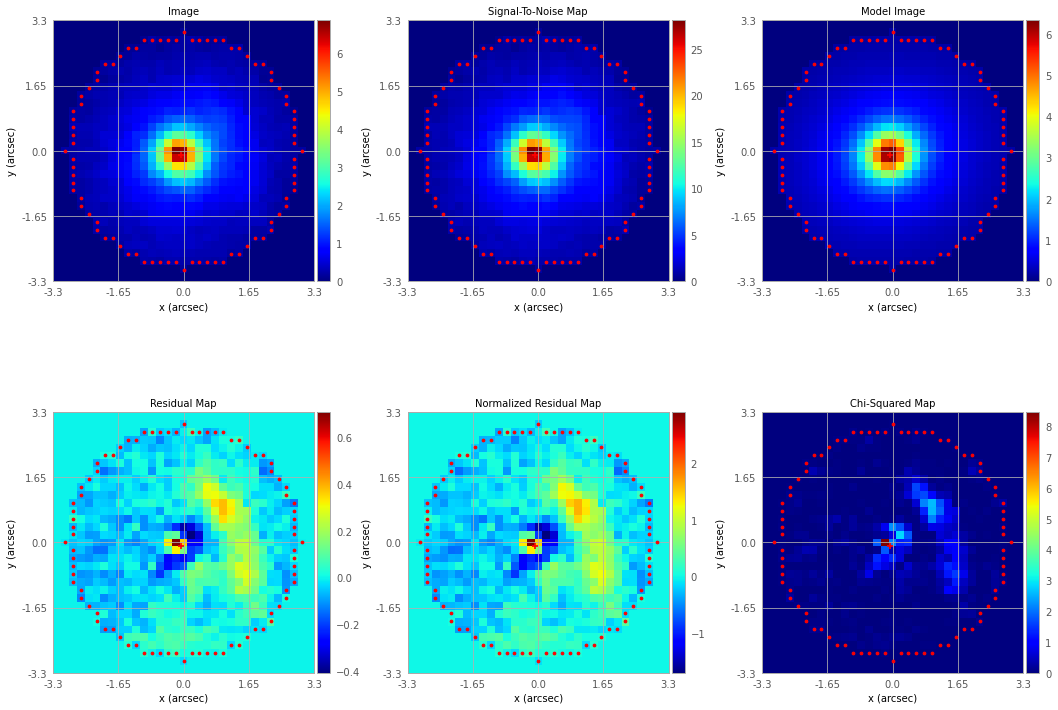

In [33]:
# append performance log
data_list = [[experiment_number, 
            phase1_time,
            phase1_result.log_likelihood,
            phase2_time, 
            phase2_result.log_likelihood,
              0, 0
             ]]
new_dataframe_entry = pd.DataFrame(data_list,
                                  columns=['Experiment', 
                                           'phase1_time', 
                                           'phase1_likelihood', 
                                           'phase2_time', 
                                           'phase2_likelihood', 
                                           'phase3_time',
                                           'phase3_likelihood'
                                           ])
performance_log = pd.concat([performance_log, new_dataframe_entry])
print(performance_log)
performance_log.to_csv(f'{csv_path}G3575500_performance_log.csv')
#print(phase_result.model)
# get samples to see how it ran?
#log_likelihoods = phase_result.samples.log_likelihoods
#x = np.arange(0, len(log_likelihoods), 1)
#plt.plot(x[500:], log_likelihoods[500:])
#plt.xlim()

# plot it!
fit_imaging_plotter = aplt.FitImagingPlotter(fit=phase1_result.max_log_likelihood_fit)
fit_imaging_plotter.subplot_fit_imaging()

## Experiment 1-2: Effective radius (0.65 - 10.0)

In [35]:
# set experiment number
experiment_number = 'DM_1-2_eff_radius_0.65-10.0'

# effective radius
lens_start.bulge.effective_radius = af.UniformPrior(lower_limit=0.65, upper_limit=10.0) # why have I chosen 3 here?

# set up phase
phase1 = al.PhaseImaging(
    search=af.DynestyStatic(
        path_prefix="G3575500/DM_experiments", name=f"experiment_{experiment_number}_r_fit_{datetime}", n_live_points=40,
        evidence_tolerance=1
    ),
    settings=settings,
    galaxies=af.CollectionPriorModel(lens=lens_start)#, source=source)
)

In [36]:
# run the phase
print('Phase running...')
tick = time.perf_counter()
phase1_result = phase1.run(dataset=imaging_r, mask=mask)
tock = time.perf_counter()
print(f'Work complete! Took us {tock-tick} seconds or {(tock-tick)/60} minutes.')

INFO:root:Generating initial samples of model, which are subject to prior limits and other constraints.


Phase running...


INFO:root:No Dynesty samples found, beginning new non-linear search. 
284it [00:12, 22.06it/s, +40 | bound: 33 | nc: 1 | ncall: 2547 | eff(%): 12.721 | loglstar:   -inf < 217.195 <    inf | logz: 205.776 +/-    nan | dlogz:  1.099 >  1.000]
INFO:root:2500 Iterations: Performing update (Visualization, outputting samples, etc.).
541it [00:12, 43.42it/s, +40 | bound: 99 | nc: 1 | ncall: 5048 | eff(%): 11.510 | loglstar:   -inf < 298.071 <    inf | logz: 280.334 +/-    nan | dlogz:  1.080 >  1.000]
INFO:root:5000 Iterations: Performing update (Visualization, outputting samples, etc.).
784it [00:11, 69.83it/s, +40 | bound: 160 | nc: 1 | ncall: 7303 | eff(%): 11.283 | loglstar:   -inf < 301.656 <    inf | logz: 282.369 +/-    nan | dlogz:  0.022 >  1.000]
INFO:root:7500 Iterations: Performing update (Visualization, outputting samples, etc.).
784it [00:00, 501041.34it/s, +40 | bound: 160 | nc: 1 | ncall: 7303 | eff(%): 11.283 | loglstar:   -inf < 301.656 <    inf | logz: 282.369 +/-    nan | 

Work complete! Took us 57.42644210904837 seconds or 0.9571073684841395 minutes.


Log likelihood: 301.656091257234


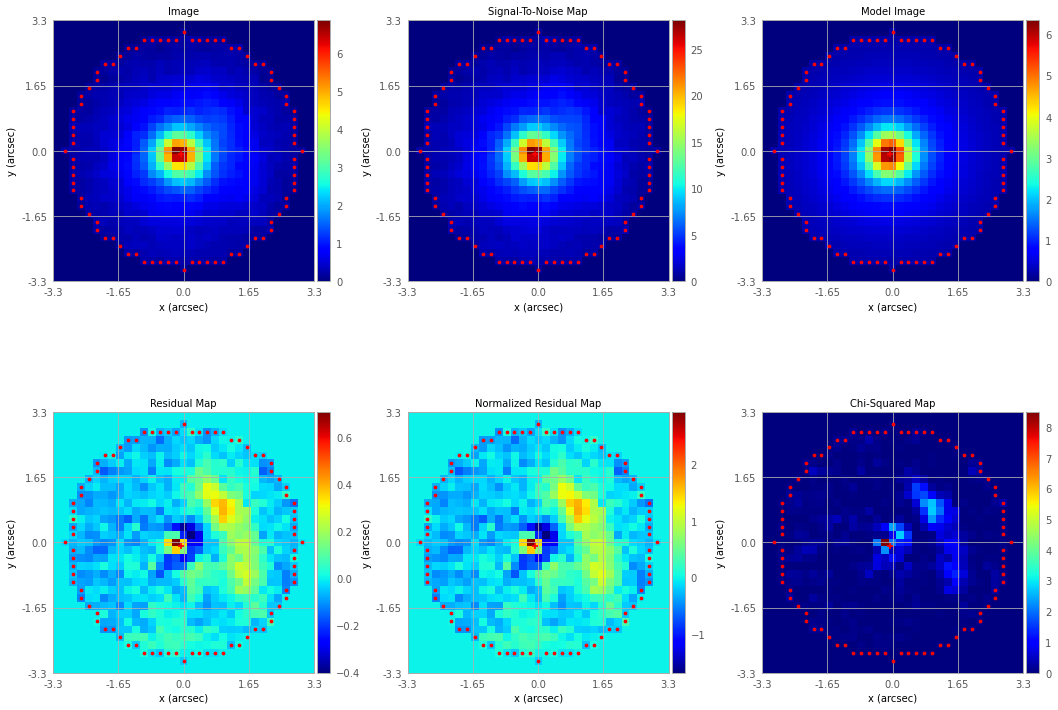

In [37]:
# write the results to the log
print(f'Log likelihood: {phase1_result.log_likelihood}')

phase1_time = tock-tick

# plot it!
fit_imaging_plotter = aplt.FitImagingPlotter(fit=phase1_result.max_log_likelihood_fit)
fit_imaging_plotter.subplot_fit_imaging()

In [38]:
# now phase 2!

#set up lens and source

# set stellar mass/light profile
bulge = af.PriorModel(al.lmp.EllipticalSersic)
bulge.take_attributes(source=phase1_result.model.galaxies.lens.bulge)

# set dark matter profile
dark = af.PriorModel(al.mp.SphericalNFWMCRLudlow)
dark.mass_at_200 = af.LogUniformPrior(lower_limit=1e8, upper_limit=1e15)
dark.redshift_object = zlens
dark.redshift_source = zsource

lens = al.GalaxyModel(
    redshift=zlens, bulge=bulge, dark=dark
)

source = al.GalaxyModel(
    redshift=zsource, bulge=al.lp.SphericalExponential)

# make lens intensity default to 0.1 +- 0.1 because red to green makes it wonky
lens.bulge.intensity = af.GaussianPrior(mean=0.1, sigma=0.1)

# set uniform m_l ratio
#lens.bulge.mass_to_light_ratio = af.UniformPrior(lower_limit=0.0, upper_limit=100000.0) # leave it default

# make dark matter centered at stellar mass center
lens.dark.centre = lens.bulge.centre

# einstein radius
#lens.mass.einstein_radius = af.GaussianPrior(mean=einstein_radius, sigma=0.3*einstein_radius) # take sigma to be 30% of mean # hmmm

# source position
source.bulge.centre_0 = af.UniformPrior(lower_limit=-3, upper_limit=3)
source.bulge.centre_1 = af.UniformPrior(lower_limit=-3, upper_limit=3)
source.bulge.effective_radius = af.UniformPrior(lower_limit=0.0, upper_limit=10.0)

In [39]:
# set the settings to include the positions
#settings_lens = al.SettingsLens(positions_threshold=2.0)

settings = al.SettingsPhaseImaging(
    settings_masked_imaging=settings_masked_imaging#, settings_lens=settings_lens
)

In [40]:
# set up phase
phase2 = al.PhaseImaging(
    search=af.DynestyStatic(
        path_prefix="G3575500/DM_experiments", name=f"experiment_{experiment_number}_g_fit_{datetime}", n_live_points=120,
        evidence_tolerance=0.5, walks=10, facc=0.4
    ),
    settings=settings,
    galaxies=af.CollectionPriorModel(lens=lens, source=source)#, source=source)
)

In [41]:
# run phase
# run the phase
print('Phase running...')
tick = time.perf_counter()
phase2_result = phase2.run(dataset=imaging_g, mask=mask)
tock = time.perf_counter()
print(f'Work complete! Took us {tock-tick} seconds or {(tock-tick)/60} minutes.')

INFO:root:Generating initial samples of model, which are subject to prior limits and other constraints.


Phase running...


INFO:root:No Dynesty samples found, beginning new non-linear search. 
340it [02:07,  2.67it/s, +120 | bound: 0 | nc: 1 | ncall: 2656 | eff(%): 17.319 | loglstar:   -inf < 111.403 <    inf | logz: 103.251 +/-  1.393 | dlogz:  0.996 >  0.500]   
INFO:root:2500 Iterations: Performing update (Visualization, outputting samples, etc.).
501it [02:08,  3.89it/s, +120 | bound: 8 | nc: 1 | ncall: 5164 | eff(%): 12.026 | loglstar:   -inf < 116.391 <    inf | logz: 107.347 +/-  1.194 | dlogz:  0.740 >  0.500]
INFO:root:5000 Iterations: Performing update (Visualization, outputting samples, etc.).
734it [02:18,  5.30it/s, +120 | bound: 22 | nc: 1 | ncall: 7757 | eff(%): 11.009 | loglstar:   -inf < 116.738 <    inf | logz: 107.217 +/-  0.936 | dlogz:  0.227 >  0.500]
INFO:root:7500 Iterations: Performing update (Visualization, outputting samples, etc.).
969it [02:12,  7.30it/s, +120 | bound: 36 | nc: 1 | ncall: 10262 | eff(%): 10.612 | loglstar:   -inf < 117.043 <    inf | logz: 107.414 +/-  0.558 | 

Work complete! Took us 805.9918376393616 seconds or 13.43319729398936 minutes.


In [42]:
# write the results to the log
print(f'Log likelihood: {phase2_result.log_likelihood}')

phase2_time=tock-tick

log = open(f"{autoz_path}output/G3575500/dark_experiment_log_G3575500", 'a') # append the log
lines = [f'Experiment {experiment_number} \n',
         f'r-band \n',
         f'Time to convergence: {phase1_time} seconds \n', 
         f'Log likelihood: {phase1_result.log_likelihood} \n',
         f'Model: {str(phase1_result.model)} \n',
         f'g-band \n',
         f'Time to convergence: {phase2_time} seconds \n', 
         f'Log likelihood: {phase2_result.log_likelihood} \n', 
         f'Model: {str(phase2_result.model)} \n', '\n'] # set lines to write the model result
log.writelines(lines) # write lines
log.close()

Log likelihood: 117.59520107161606


    Unnamed: 0  Unnamed: 0.1                   Experiment  phase1_time  \
0          0.0           0.0                          1-1   107.555079   
1          1.0           0.0                          1-2   137.521799   
2          2.0           0.0                          1-3   104.364316   
3          3.0           0.0                          1-4    73.453015   
4          4.0           0.0                          1-5    40.029995   
5          5.0           0.0                          1-6    34.548316   
6          6.0           0.0                          1-7    11.370712   
7          7.0           0.0                          2-1    31.438987   
8          8.0           0.0                          2-2    30.512206   
9          9.0           0.0                          2-3    33.163424   
10        10.0           0.0                          2-4    34.001947   
11        11.0           0.0                          2-5    34.957396   
12        12.0           0.0          

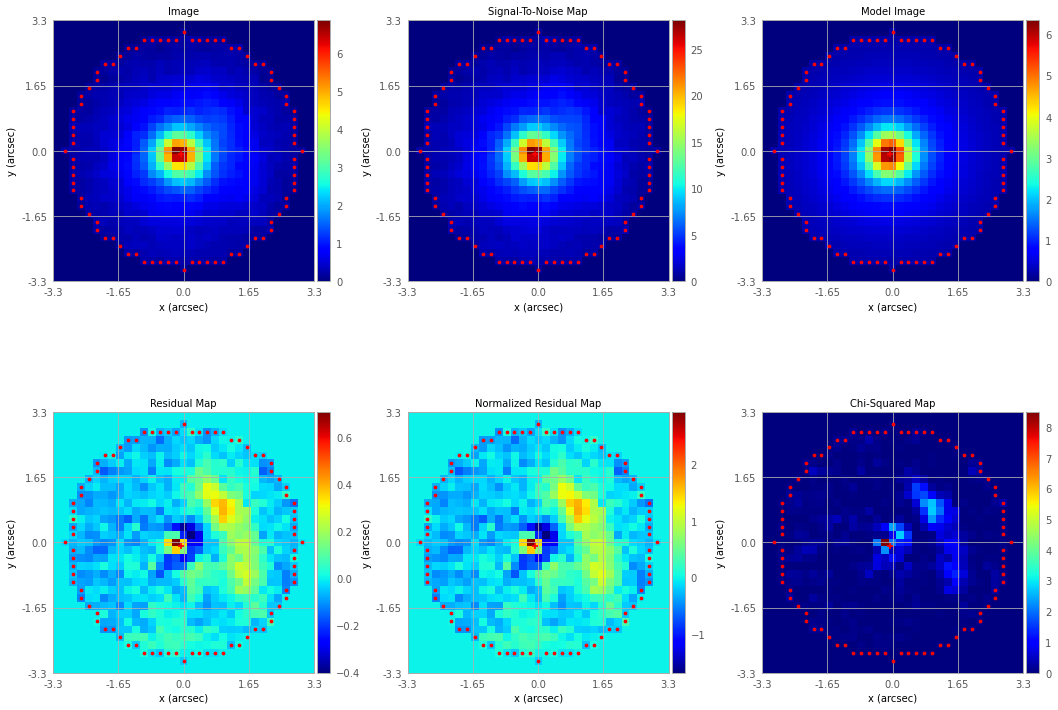

In [43]:
# append performance log
data_list = [[experiment_number, 
            phase1_time,
            phase1_result.log_likelihood,
            phase2_time, 
            phase2_result.log_likelihood,
              0, 0
             ]]
new_dataframe_entry = pd.DataFrame(data_list,
                                  columns=['Experiment', 
                                           'phase1_time', 
                                           'phase1_likelihood', 
                                           'phase2_time', 
                                           'phase2_likelihood', 
                                           'phase3_time',
                                           'phase3_likelihood'
                                           ])
performance_log = pd.concat([performance_log, new_dataframe_entry])
print(performance_log)
performance_log.to_csv(f'{csv_path}G3575500_performance_log.csv')
#print(phase_result.model)
# get samples to see how it ran?
#log_likelihoods = phase_result.samples.log_likelihoods
#x = np.arange(0, len(log_likelihoods), 1)
#plt.plot(x[500:], log_likelihoods[500:])
#plt.xlim()

# plot it!
fit_imaging_plotter = aplt.FitImagingPlotter(fit=phase1_result.max_log_likelihood_fit)
fit_imaging_plotter.subplot_fit_imaging()

## Experiment 1-3: Effective radius at default (0-30)

In [46]:
# set experiment number
experiment_number = 'DM_1-3_eff_radius_default'

# effective radius
#lens_start.bulge.effective_radius = af.UniformPrior(lower_limit=0.65, upper_limit=10.0) # why have I chosen 3 here?

# set up phase
phase1 = al.PhaseImaging(
    search=af.DynestyStatic(
        path_prefix="G3575500/DM_experiments", name=f"experiment_{experiment_number}_r_fit_{datetime}", n_live_points=40,
        evidence_tolerance=1
    ),
    settings=settings,
    galaxies=af.CollectionPriorModel(lens=lens_start)#, source=source)
)

print(lens_start)

Galaxy (centre_0, UniformPrior, lower_limit = -0.1, upper_limit = 0.1), (centre_1, UniformPrior, lower_limit = -0.1, upper_limit = 0.1), (elliptical_comps_0, GaussianPrior, mean = 0.0, sigma = 0.3), (elliptical_comps_1, GaussianPrior, mean = 0.0, sigma = 0.3), (intensity, LogUniformPrior, lower_limit = 1e-06, upper_limit = 1000000.0), (effective_radius, LogUniformPrior, lower_limit = 0.0001, upper_limit = 30.0), (sersic_index, UniformPrior, lower_limit = 0.5, upper_limit = 8.0)


In [47]:
# run the phase
print('Phase running...')
tick = time.perf_counter()
phase1_result = phase1.run(dataset=imaging_r, mask=mask)
tock = time.perf_counter()
print(f'Work complete! Took us {tock-tick} seconds or {(tock-tick)/60} minutes.')

INFO:root:Generating initial samples of model, which are subject to prior limits and other constraints.


Phase running...


INFO:root:No Dynesty samples found, beginning new non-linear search. 
281it [00:12, 21.76it/s, +40 | bound: 23 | nc: 1 | ncall: 2547 | eff(%): 12.603 | loglstar:   -inf < -11.517 <    inf | logz: -22.863 +/-    nan | dlogz:  1.099 >  1.000] 
INFO:root:2500 Iterations: Performing update (Visualization, outputting samples, etc.).
562it [00:12, 43.91it/s, +40 | bound: 92 | nc: 1 | ncall: 5052 | eff(%): 11.916 | loglstar:   -inf < 298.616 <    inf | logz: 280.332 +/-    nan | dlogz:  1.098 >  1.000]
INFO:root:5000 Iterations: Performing update (Visualization, outputting samples, etc.).
839it [00:12, 66.74it/s, +40 | bound: 161 | nc: 1 | ncall: 7556 | eff(%): 11.633 | loglstar:   -inf < 301.576 <    inf | logz: 279.397 +/-    nan | dlogz:  0.100 >  1.000]
INFO:root:7500 Iterations: Performing update (Visualization, outputting samples, etc.).
896it [00:02, 325.02it/s, +40 | bound: 176 | nc: 1 | ncall: 8107 | eff(%): 11.546 | loglstar:   -inf < 301.612 <    inf | logz: 279.487 +/-    nan | dl

Work complete! Took us 65.1961566992104 seconds or 1.0866026116535068 minutes.


Log likelihood: 301.6121777715229


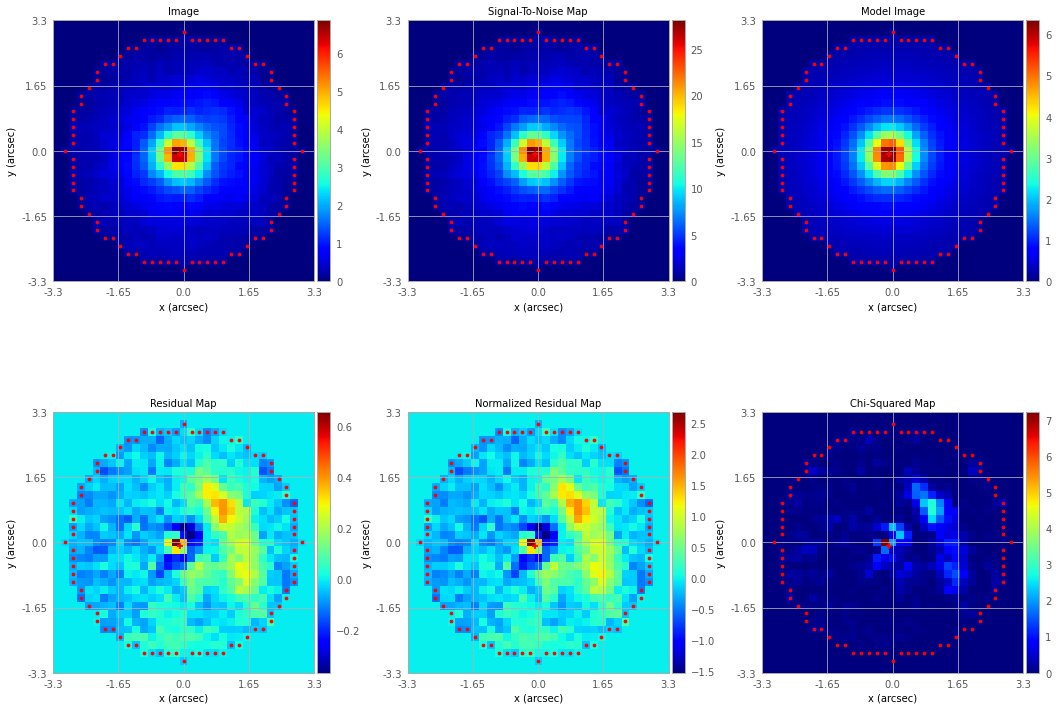

In [48]:
# write the results to the log
print(f'Log likelihood: {phase1_result.log_likelihood}')

phase1_time = tock-tick

# plot it!
fit_imaging_plotter = aplt.FitImagingPlotter(fit=phase1_result.max_log_likelihood_fit)
fit_imaging_plotter.subplot_fit_imaging()

In [49]:
# now phase 2!

#set up lens and source

# set stellar mass/light profile
bulge = af.PriorModel(al.lmp.EllipticalSersic)
bulge.take_attributes(source=phase1_result.model.galaxies.lens.bulge)

# set dark matter profile
dark = af.PriorModel(al.mp.SphericalNFWMCRLudlow)
dark.mass_at_200 = af.LogUniformPrior(lower_limit=1e8, upper_limit=1e15)
dark.redshift_object = zlens
dark.redshift_source = zsource

lens = al.GalaxyModel(
    redshift=zlens, bulge=bulge, dark=dark
)

source = al.GalaxyModel(
    redshift=zsource, bulge=al.lp.SphericalExponential)

# make lens intensity default to 0.1 +- 0.1 because red to green makes it wonky
lens.bulge.intensity = af.GaussianPrior(mean=0.1, sigma=0.1)

# set uniform m_l ratio
#lens.bulge.mass_to_light_ratio = af.UniformPrior(lower_limit=0.0, upper_limit=100000.0) # leave it default

# make dark matter centered at stellar mass center
lens.dark.centre = lens.bulge.centre

# einstein radius
#lens.mass.einstein_radius = af.GaussianPrior(mean=einstein_radius, sigma=0.3*einstein_radius) # take sigma to be 30% of mean # hmmm

# source position
source.bulge.centre_0 = af.UniformPrior(lower_limit=-3, upper_limit=3)
source.bulge.centre_1 = af.UniformPrior(lower_limit=-3, upper_limit=3)
#source.bulge.effective_radius = af.UniformPrior(lower_limit=0.0, upper_limit=10.0)

In [50]:
# set the settings to include the positions
#settings_lens = al.SettingsLens(positions_threshold=2.0)

settings = al.SettingsPhaseImaging(
    settings_masked_imaging=settings_masked_imaging#, settings_lens=settings_lens
)

In [51]:
# set up phase
phase2 = al.PhaseImaging(
    search=af.DynestyStatic(
        path_prefix="G3575500/DM_experiments", name=f"experiment_{experiment_number}_g_fit_{datetime}", n_live_points=120,
        evidence_tolerance=0.5, walks=10, facc=0.4
    ),
    settings=settings,
    galaxies=af.CollectionPriorModel(lens=lens, source=source)#, source=source)
)

In [52]:
# run phase
# run the phase
print('Phase running...')
tick = time.perf_counter()
phase2_result = phase2.run(dataset=imaging_g, mask=mask)
tock = time.perf_counter()
print(f'Work complete! Took us {tock-tick} seconds or {(tock-tick)/60} minutes.')

INFO:root:Generating initial samples of model, which are subject to prior limits and other constraints.


Phase running...


INFO:root:No Dynesty samples found, beginning new non-linear search. 
336it [01:58,  2.83it/s, +120 | bound: 0 | nc: 1 | ncall: 2642 | eff(%): 17.260 | loglstar:   -inf < 110.665 <    inf | logz: 102.402 +/-  1.625 | dlogz:  1.089 >  0.500]    
INFO:root:2500 Iterations: Performing update (Visualization, outputting samples, etc.).
463it [02:01,  3.80it/s, +120 | bound: 7 | nc: 1 | ncall: 5147 | eff(%): 11.327 | loglstar:   -inf < 115.487 <    inf | logz: 106.334 +/-  1.319 | dlogz:  0.983 >  0.500]
INFO:root:5000 Iterations: Performing update (Visualization, outputting samples, etc.).
680it [02:15,  5.03it/s, +120 | bound: 21 | nc: 1 | ncall: 7649 | eff(%): 10.459 | loglstar:   -inf < 115.487 <    inf | logz: 105.719 +/-  1.115 | dlogz:  0.413 >  0.500]
INFO:root:7500 Iterations: Performing update (Visualization, outputting samples, etc.).
914it [02:14,  6.81it/s, +120 | bound: 34 | nc: 1 | ncall: 10157 | eff(%): 10.180 | loglstar:   -inf < 116.225 <    inf | logz: 106.147 +/-  0.703 |

Work complete! Took us 899.4060708172619 seconds or 14.990101180287699 minutes.


In [53]:
# write the results to the log
print(f'Log likelihood: {phase2_result.log_likelihood}')

phase2_time=tock-tick

log = open(f"{autoz_path}output/G3575500/dark_experiment_log_G3575500", 'a') # append the log
lines = [f'Experiment {experiment_number} \n',
         f'r-band \n',
         f'Time to convergence: {phase1_time} seconds \n', 
         f'Log likelihood: {phase1_result.log_likelihood} \n',
         f'Model: {str(phase1_result.model)} \n',
         f'g-band \n',
         f'Time to convergence: {phase2_time} seconds \n', 
         f'Log likelihood: {phase2_result.log_likelihood} \n', 
         f'Model: {str(phase2_result.model)} \n', '\n'] # set lines to write the model result
log.writelines(lines) # write lines
log.close()

Log likelihood: 117.04381754954896


    Unnamed: 0  Unnamed: 0.1                   Experiment  phase1_time  \
0          0.0           0.0                          1-1   107.555079   
1          1.0           0.0                          1-2   137.521799   
2          2.0           0.0                          1-3   104.364316   
3          3.0           0.0                          1-4    73.453015   
4          4.0           0.0                          1-5    40.029995   
5          5.0           0.0                          1-6    34.548316   
6          6.0           0.0                          1-7    11.370712   
7          7.0           0.0                          2-1    31.438987   
8          8.0           0.0                          2-2    30.512206   
9          9.0           0.0                          2-3    33.163424   
10        10.0           0.0                          2-4    34.001947   
11        11.0           0.0                          2-5    34.957396   
12        12.0           0.0          

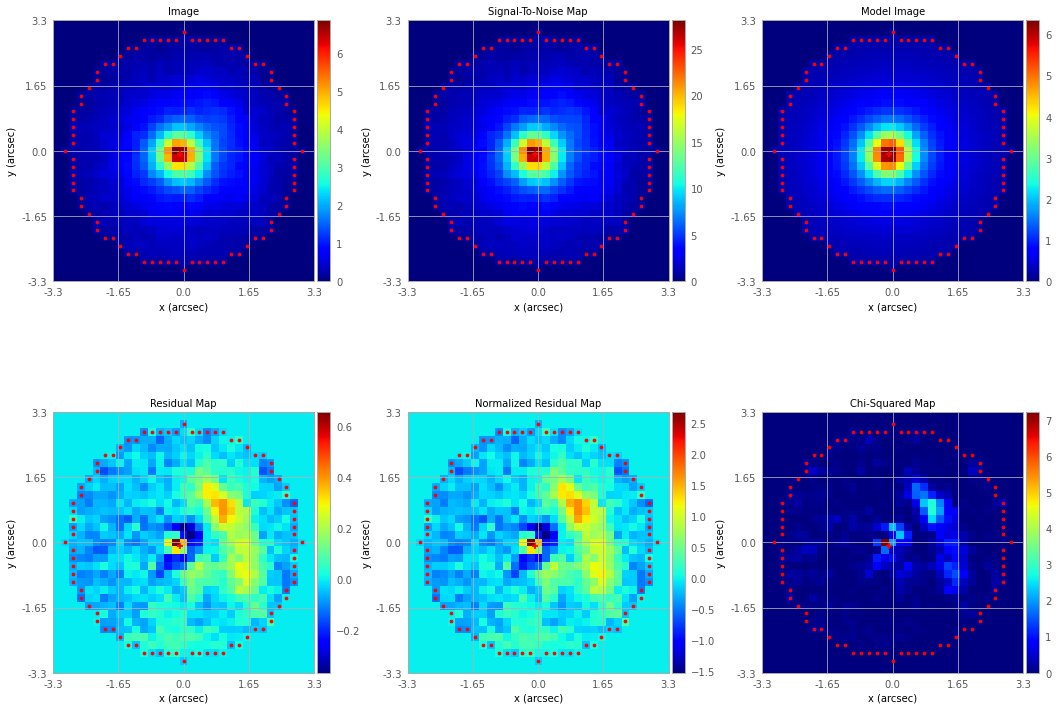

In [54]:
# append performance log
data_list = [[experiment_number, 
            phase1_time,
            phase1_result.log_likelihood,
            phase2_time, 
            phase2_result.log_likelihood,
              0, 0
             ]]
new_dataframe_entry = pd.DataFrame(data_list,
                                  columns=['Experiment', 
                                           'phase1_time', 
                                           'phase1_likelihood', 
                                           'phase2_time', 
                                           'phase2_likelihood', 
                                           'phase3_time',
                                           'phase3_likelihood'
                                           ])
performance_log = pd.concat([performance_log, new_dataframe_entry])
print(performance_log)
performance_log.to_csv(f'{csv_path}G3575500_performance_log.csv')
#print(phase_result.model)
# get samples to see how it ran?
#log_likelihoods = phase_result.samples.log_likelihoods
#x = np.arange(0, len(log_likelihoods), 1)
#plt.plot(x[500:], log_likelihoods[500:])
#plt.xlim()

# plot it!
fit_imaging_plotter = aplt.FitImagingPlotter(fit=phase1_result.max_log_likelihood_fit)
fit_imaging_plotter.subplot_fit_imaging()